In [2]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/simulation_prox/new_simulation_figures/"
os.chdir(myDir)
import ProxseqClasses as PC

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
#*****
# Seed number
np.random.seed(2019)
random.seed(2019)

#%% Simulation parameters
# Define the circle diameter in nm, centered at 0
d = 10000

# PLA ligation distance in nm (two antibodies within this distance can be ligated)
PLA_dist = 50

# Binomial distribution
p = (PLA_dist/d)**2

In [3]:
#%% Import real data
dge_real = pd.read_csv("/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/simulation_reproduce figures/tutorial_count_matrix.txt.gz", index_col=0, delimiter="\t")

# Filter cells
# Keep cells with > 10 UMIs and below 30k UMIs
dge_real = dge_real.loc[:,(dge_real.sum(axis=0)>10) & (dge_real.sum(axis=0)<30000)]
# Keep cells with more than 20 detected PLA products
dge_real = dge_real.loc[:,((dge_real>0).sum(axis=0)>20)]

# Cell-type data
dge_real_T = dge_real.loc[:,dge_real.columns.str.contains("Jurkat")]
dge_real_B = dge_real.loc[:,dge_real.columns.str.contains("Raji")]
pla_T = PC.plaObject(dge_real_T, non_proximal_marker="free_oligo")
pla_T2 = PC.plaObject(dge_real_T, non_proximal_marker="free_oligo")
pla_B = PC.plaObject(dge_real_B, non_proximal_marker="free_oligo")
pla_B2 = PC.plaObject(dge_real_B, non_proximal_marker="free_oligo")

In [4]:
pla_T.calculateProteinCount()
pla_T.predictComplex(method='lr', suffix='2')
pla_T_random = pla_T.pla_count - pla_T.complex_count2

/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/simulation_reproduce figures/ProxseqClasses.py:701: RuntimeWarning: divide by zero encountered in double_scalars
  t_intercept = (results.params[0] - intercept_cutoff)/results.bse[0]
/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/simulation_reproduce figures/ProxseqClasses.py:703: RuntimeWarning: invalid value encountered in double_scalars
  t_slope = (results.params[1] - slope_cutoff)/results.bse[1]


In [5]:
U_all_pla = []
U_all_protein = []
U_all_complex = []
U_all_random = []
for i in range(pla_T.pla_count.shape[0]):
    mean = pla_T.pla_count.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    Uval,Up = stats.mannwhitneyu(pla_T.pla_count.iloc[i,:],sample)
    U_all_pla.append(Uval)
    
for i in range(pla_T.complex_count2.shape[0]):
    mean = pla_T.complex_count2.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    Uval,Up = stats.mannwhitneyu(pla_T.complex_count2.iloc[i,:],sample)
    U_all_complex.append(Uval)
    
for i in range(pla_T_random.shape[0]):
    mean = pla_T_random.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    Uval,Up = stats.mannwhitneyu(pla_T_random.iloc[i,:],sample)
    U_all_random.append(Uval)
    
for i in range(pla_T.protein_count.shape[0]):
    mean = pla_T.protein_count.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    Uval,Up = stats.mannwhitneyu(pla_T.protein_count.iloc[i,:],sample)
    U_all_protein.append(Uval)

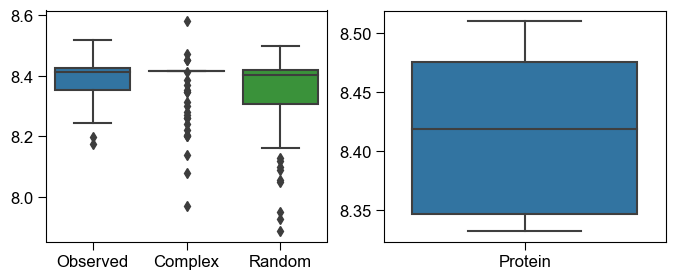

In [7]:
U_all = pd.DataFrame({'Observed':np.log(U_all_pla),
                      'Complex':np.log(U_all_complex),
                      'Random':np.log(U_all_random)})
U_all_protein_pd = pd.DataFrame({'Protein':np.log(U_all_protein)})
fig, ax = plt.subplots(ncols=2, figsize=(8,3))
sns.boxplot(data=U_all,ax=ax[0])
sns.boxplot(data=U_all_protein_pd,ax=ax[1])
fig.savefig(myDir+"posterior predictive checks with Mann–Whitney U-test statistic.svg", bbox_inches='tight', pad_inches=0)

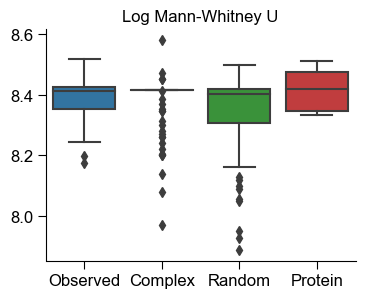

In [8]:
df = pd.concat([U_all,U_all_protein_pd],axis=1)
fig,ax = plt.subplots(figsize=(4,3))
sns.boxplot(data=df,ax=ax)
ax.set_title('Log Mann-Whitney U')
sns.despine(fig=fig)
fig.savefig(myDir+"posterior predictive checks with Mann–Whitney U-test statistic.svg", bbox_inches='tight', pad_inches=0)

In [48]:
var_all_pla = []
var_all_protein = []
var_all_complex = []
var_all_random = []
for i in range(pla_T.pla_count.shape[0]):
    mean = pla_T.pla_count.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    var = np.var(sample)
    var_all_pla.append(var)

    
for i in range(pla_T.complex_count2.shape[0]):
    mean = pla_T.complex_count2.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    var = np.var(sample)
    var_all_complex.append(var)
    
for i in range(pla_T_random.shape[0]):
    mean = pla_T_random.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    var = np.var(sample)
    var_all_random.append(var)

for i in range(pla_T.protein_count.shape[0]):
    mean = pla_T.protein_count.iloc[i,:].mean()
    sample = np.random.negative_binomial(n=1.5,p=1.5/(mean+1.5),size=95)
    var = np.var(sample)
    var_all_protein.append(var)

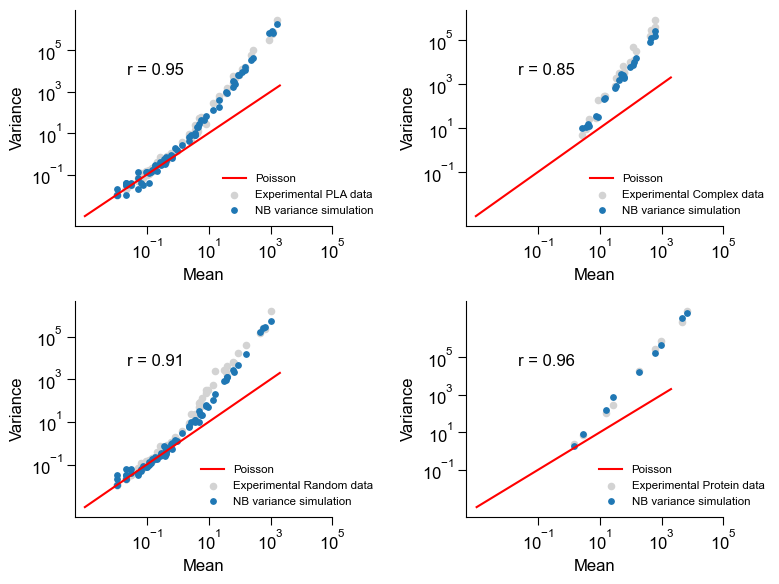

In [90]:
fig,ax = plt.subplots(figsize=(8,6),ncols=2,nrows=2)
ax[0,0].scatter(pla_T.pla_count.mean(axis=1), pla_T.pla_count.var(axis=1),
           color='lightgrey', s=20, label="Experimental PLA data")
ax[0,0].scatter(pla_T.pla_count.mean(axis=1), var_all_pla,
           s=15, label="NB variance simulation")
ax[0,0].plot([1e-3,2e3],[1e-3,2e3], color='red', label="Poisson")
pearsonr = stats.pearsonr(pla_T.pla_count.var(axis=1),var_all_pla)
ax[0,0].text(0.2,0.7, f"r = {pearsonr[0]:.2f}", transform=ax[0,0].transAxes)
ax[0,1].scatter(pla_T.complex_count2.mean(axis=1), pla_T.complex_count2.var(axis=1),
           color='lightgrey', s=20, label="Experimental Complex data")
ax[0,1].scatter(pla_T.complex_count2.mean(axis=1), var_all_complex,
           s=15, label="NB variance simulation")
ax[0,1].plot([1e-3,2e3],[1e-3,2e3], color='red', label="Poisson")
pearsonr = stats.pearsonr(pla_T.complex_count2.var(axis=1),var_all_complex)
ax[0,1].text(0.2,0.7, f"r = {pearsonr[0]:.2f}", transform=ax[0,1].transAxes)
ax[1,0].scatter(pla_T_random.mean(axis=1), pla_T_random.var(axis=1),
           color='lightgrey', s=20, label="Experimental Random data")
ax[1,0].scatter(pla_T_random.mean(axis=1), var_all_random,
           s=15, label="NB variance simulation")
ax[1,0].plot([1e-3,2e3],[1e-3,2e3], color='red', label="Poisson")
pearsonr = stats.pearsonr(pla_T_random.var(axis=1),var_all_random)
ax[1,0].text(0.2,0.7, f"r = {pearsonr[0]:.2f}", transform=ax[1,0].transAxes)
ax[1,1].scatter(pla_T.protein_count.mean(axis=1), pla_T.protein_count.var(axis=1),
           color='lightgrey', s=20, label="Experimental Protein data")
ax[1,1].scatter(pla_T.protein_count.mean(axis=1), var_all_protein,
           s=15, label="NB variance simulation")
ax[1,1].plot([1e-3,2e3],[1e-3,2e3], color='red', label="Poisson")
pearsonr = stats.pearsonr(pla_T.protein_count.var(axis=1),var_all_protein)
ax[1,1].text(0.2,0.7, f"r = {pearsonr[0]:.2f}", transform=ax[1,1].transAxes)
for i in range(2):
    for j in range(2):
        ax[i][j].set_xscale("log")
        ax[i][j].set_yscale("log")
        ax[i][j].set_xlabel("Mean")  
        ax[i][j].set_ylabel("Variance")
        ax[i][j].set_xticks([1e-1,1e1,1e3,1e5])
        ax[i][j].set_yticks([1e-1,1e1,1e3,1e5])
        ax[i][j].legend(loc='lower right',fontsize = 'x-small',frameon=False,bbox_to_anchor=(1.2,0))
sns.despine(fig=fig)
fig.tight_layout()
fig.savefig(myDir+"Mean-variance relationship between predictive samples and observed data.svg", bbox_inches='tight', pad_inches=0)

In [13]:
#parameter choice for negative binomial distribution 
U_all = []
U_all_pla = []
n = np.linspace(0.0001,0.1,num=100)
for i in range(len(n)):
    for j in range(pla_T.pla_count.shape[0]):
        mean = pla_T.pla_count.iloc[j,:].mean()
        sample = np.random.negative_binomial(n=n[i],p=n[i]/(mean+n[i]),size=95)
        Uval,Up = stats.mannwhitneyu(pla_T.pla_count.iloc[j,:],sample)
        U_all_pla.append(Uval)
    U_all.append(U_all_pla)
    U_all_pla = []

In [14]:
df = pd.DataFrame(np.log(U_all))

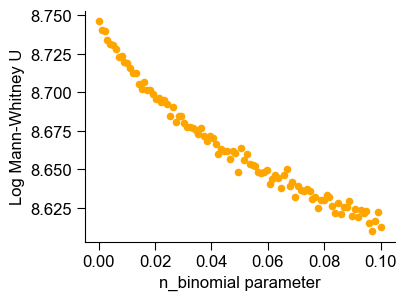

In [16]:
fig,ax = plt.subplots(figsize=(4,3))
ax.scatter(n,df.mean(axis=1),color='orange', s=20)
ax.set_ylabel('Log Mann-Whitney U')
ax.set_xlabel('n_binomial parameter')
sns.despine(fig=fig)
fig.savefig(myDir+"parameter selection_0.0001_to_0.1.svg", bbox_inches='tight', pad_inches=0)